# Exercise 3
## Group 8

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")


        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100,  60)
        self.fc4 = nn.Linear(60,   30)
        self.fc5 = nn.Linear(30,   10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # TODO: run network layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        
        return output

In [5]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100,  60)
        self.fc4 = nn.Linear(60,   30)
        self.fc5 = nn.Linear(30,   10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)


In [6]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100,  60)
        self.bn3 = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60,   30)
        self.fc5 = nn.Linear(30,   10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307897
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.605597
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.161763
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.063937
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.135343
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.064718
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.180489
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.138565
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.132932
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.305736

Test set: Average loss: 0.1213, Accuracy: 9622/10000 (96.22%)



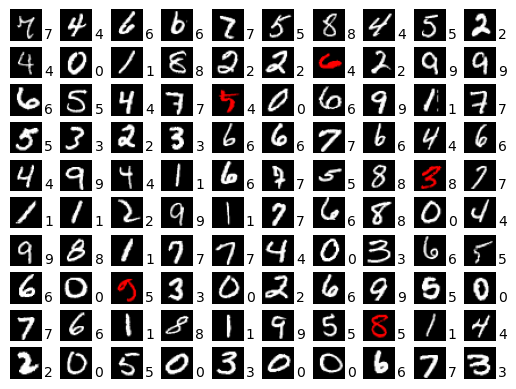

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.202924
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.085798
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.106355
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.055883
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.154145
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.041393
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.099030
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.021691
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112875
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.044012

Test set: Average loss: 0.0940, Accuracy: 9731/10000 (97.31%)



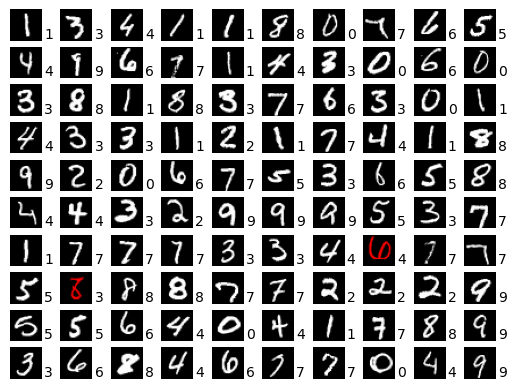

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.061818
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.002246
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.049677
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.038158
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.035242
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.043838
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.098615
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.120632
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.098692
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.072210

Test set: Average loss: 0.0879, Accuracy: 9753/10000 (97.53%)



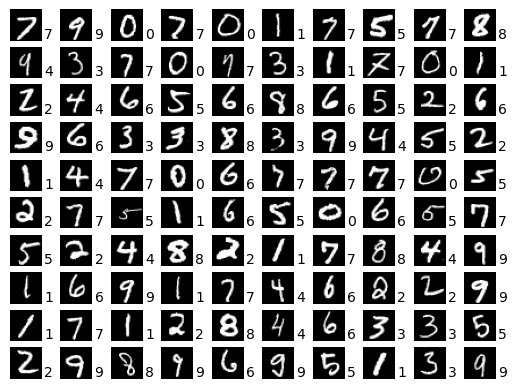

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.006416
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.048939
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.015093
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.015426
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.007317
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002146
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.017444
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.005405
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.042638
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.004657

Test set: Average loss: 0.0797, Accuracy: 9804/10000 (98.04%)



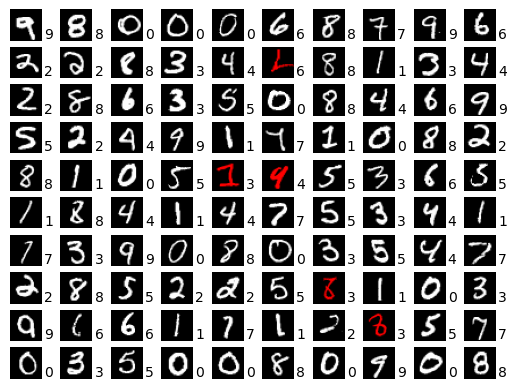

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.037098
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.001421
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.005079
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.006646
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000830
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000581
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.053738
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.064022
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.063360
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001822

Test set: Average loss: 0.0787, Accuracy: 9818/10000 (98.18%)



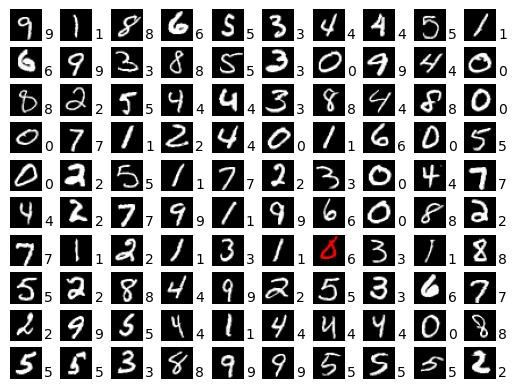

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.002306
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000422
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000805
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.005178
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.013323
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.047756
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001377
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.002371
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.003878
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000359

Test set: Average loss: 0.0827, Accuracy: 9815/10000 (98.15%)



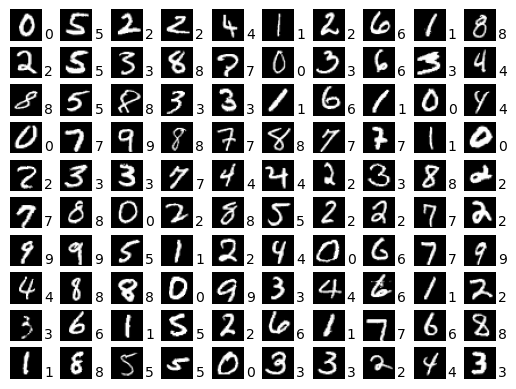

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.002552
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.006573
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.005804
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.001003
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000833
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000106
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000987
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000204
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000437
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001143

Test set: Average loss: 0.0845, Accuracy: 9826/10000 (98.26%)



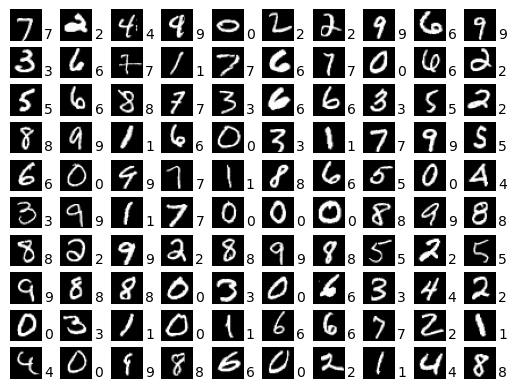

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.057244
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.002088
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.037894
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.001311
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.004954
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.015477
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000157
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.005109
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.008950
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000235

Test set: Average loss: 0.0875, Accuracy: 9828/10000 (98.28%)



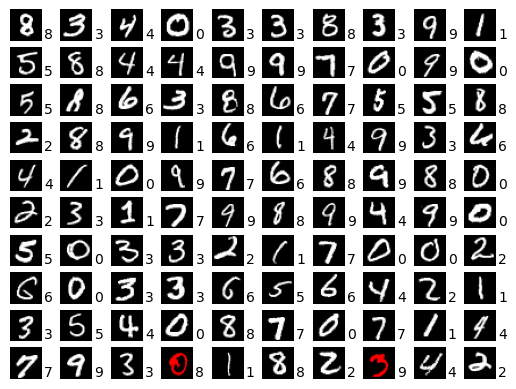

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000294
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000502
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000023
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.006567
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.014095
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001811
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000238
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000480
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.105850
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.001322

Test set: Average loss: 0.0891, Accuracy: 9828/10000 (98.28%)



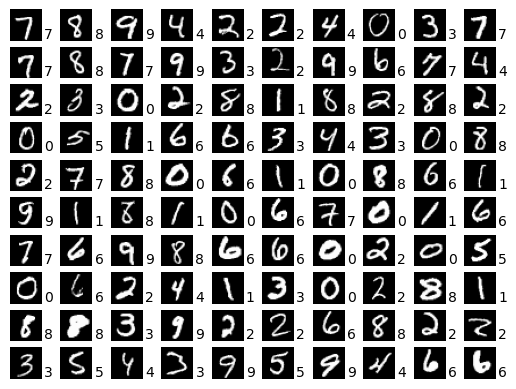

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000170
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.009316
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.003118
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000128
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.001287
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.001401
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000041
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.001021
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.002264
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.012008

Test set: Average loss: 0.0903, Accuracy: 9825/10000 (98.25%)



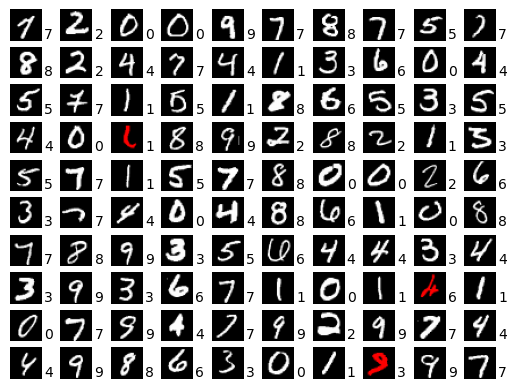

In [7]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers. This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1

* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function
 

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [8]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        # TODO: initialize network layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 2, 0), # set stride=2 -> 64 * 12 * 12
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 2, 0), # set stride=2 -> 64 * 12 * 12
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [10]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 1, 0), # -> 64 * 24 * 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # use maxpool  -> 64 * 12 * 12
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.cnn_layers(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.flatten(1)
        
        # TODO: run fully connected layers
        x = self.fc_layers(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output


Training ConvNet1...

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300482
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.323472
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.038588
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.061199
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.058803
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.058934
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.097337
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.094874
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.057431
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.111904

Test set: Average loss: 0.0616, Accuracy: 9796/10000 (97.96%)



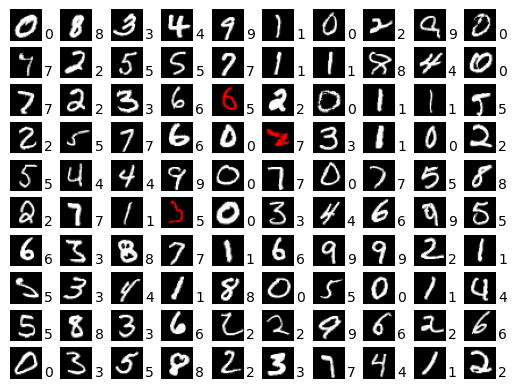

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.004908
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.009982
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003762
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.005242
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.057162
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.003138
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.006376
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.004885
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.003450
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027868

Test set: Average loss: 0.0314, Accuracy: 9899/10000 (98.99%)



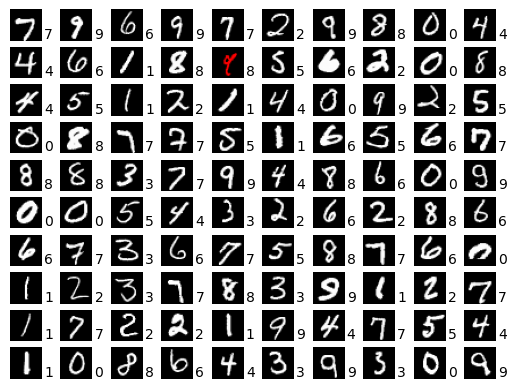

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.002695
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.002972
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.016967
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.019345
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.017894
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.001746
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.106669
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.002103
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000631
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.016078

Test set: Average loss: 0.0336, Accuracy: 9902/10000 (99.02%)



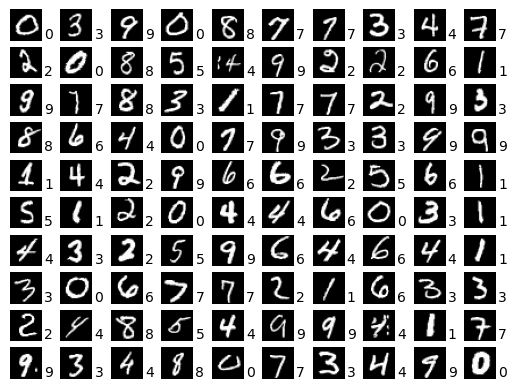

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.002989
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.001046
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000434
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001864
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000271
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.005943
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.028064
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001038
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000889
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000022

Test set: Average loss: 0.0308, Accuracy: 9914/10000 (99.14%)



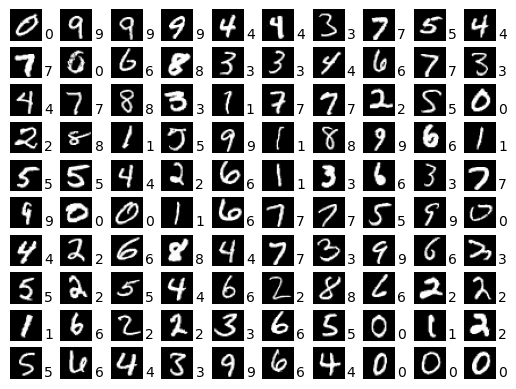

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000031
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002480
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001052
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.003556
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000100
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000129
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000543
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.001247
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000507
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001203

Test set: Average loss: 0.0315, Accuracy: 9915/10000 (99.15%)



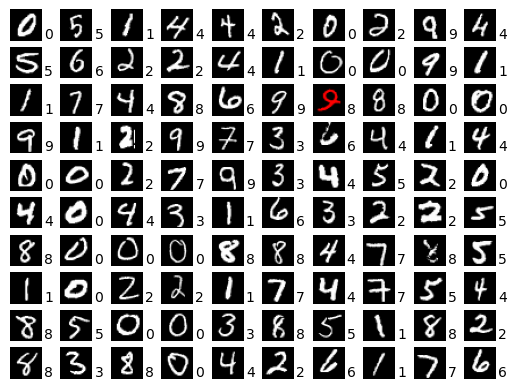


Training ConvNet2...

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.395538
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.068017
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.118122
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.140100
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.076330
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089047
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.097698
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.029008
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.159272
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.014600

Test set: Average loss: 0.0423, Accuracy: 9868/10000 (98.68%)



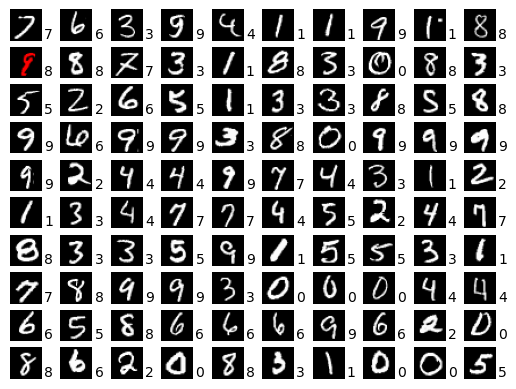

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.043878
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.010671
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.158696
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.058116
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.065838
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.093912
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.045439
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.034126
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.115349
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.003231

Test set: Average loss: 0.0416, Accuracy: 9861/10000 (98.61%)



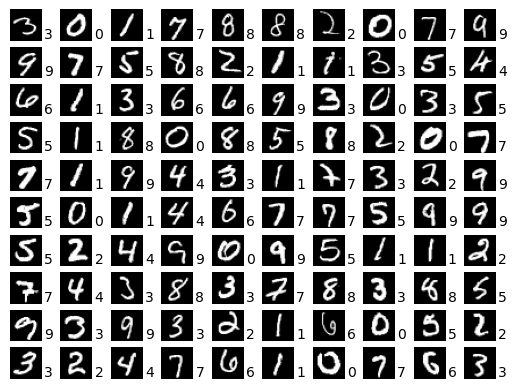

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.018805
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.002384
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.004799
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.026704
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.018184
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.018608
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.022460
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.027776
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.016200
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.018947

Test set: Average loss: 0.0265, Accuracy: 9911/10000 (99.11%)



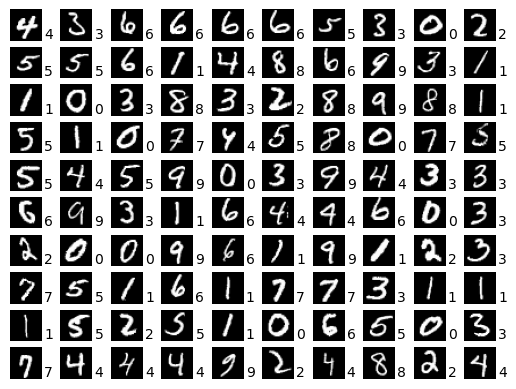

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.003356
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.040163
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000752
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.002242
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.002960
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001595
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.003135
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.003825
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.004121
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000700

Test set: Average loss: 0.0288, Accuracy: 9907/10000 (99.07%)



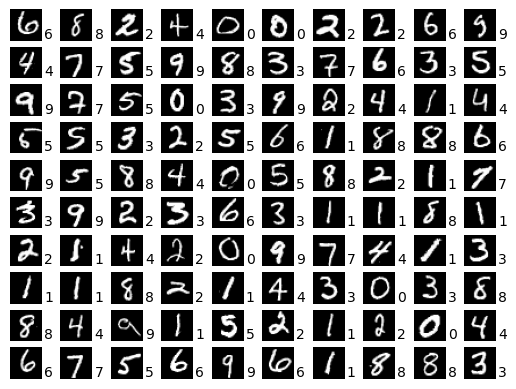

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000682
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000714
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.013072
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000311
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000129
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000756
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.004353
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.004419
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001943
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000352

Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)



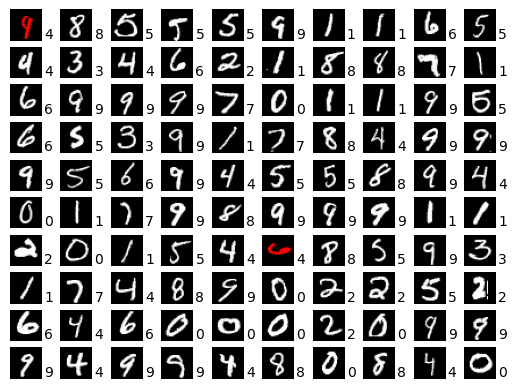


Training ConvNet3...

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.374800
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.205925
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.083379
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.058156
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.146873
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.008889
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.106708
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.021522
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.030096
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.013043

Test set: Average loss: 0.0401, Accuracy: 9870/10000 (98.70%)



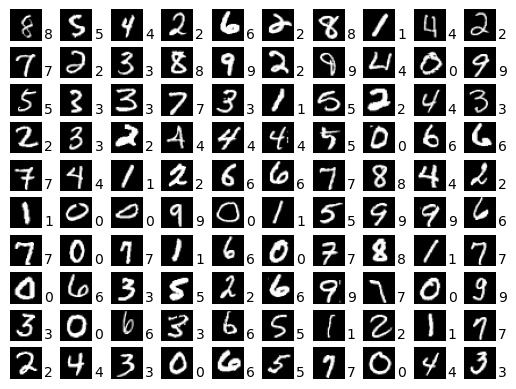

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.013626
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.052407
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.007449
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.093206
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.062073
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.060274
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.002895
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.031978
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.062794
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.003948

Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)



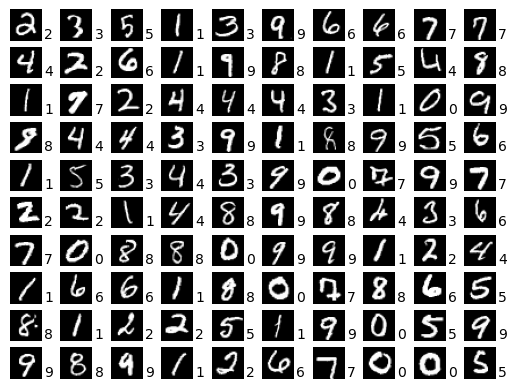

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.003447
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.031012
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.030152
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.014570
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.026432
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.015500
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.007937
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.003272
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000942
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.001401

Test set: Average loss: 0.0274, Accuracy: 9902/10000 (99.02%)



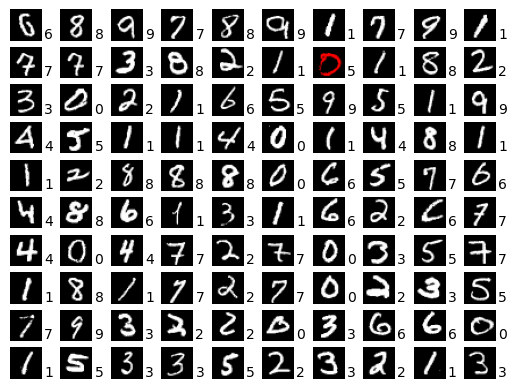

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.002786
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.002226
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.001248
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.000800
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.003854
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002038
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.005537
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.003094
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000964
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.005270

Test set: Average loss: 0.0261, Accuracy: 9918/10000 (99.18%)



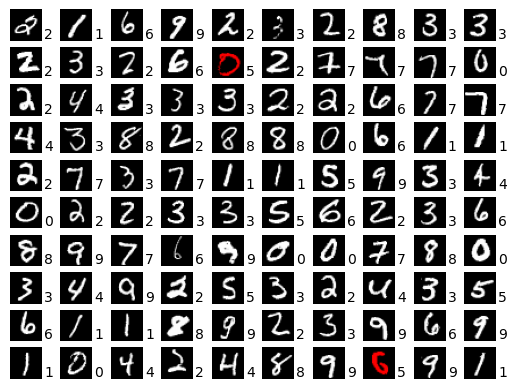

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000850
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.003326
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000388
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001496
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.004927
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000208
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.003738
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000677
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000608
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001110

Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)



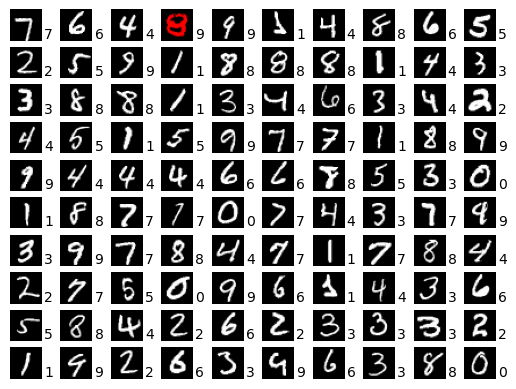

In [11]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 5
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

models = {
    "ConvNet1": ConvNet1(),
    "ConvNet2": ConvNet2(),
    "ConvNet3": ConvNet3()
}

for name, model in models.items():
    print(f"\nTraining {name}...\n")
    
    if use_cuda:
        model = model.cuda()
    
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
        validate(model, use_cuda, test_loader)
        scheduler.step()

    # Save model checkpoint
    torch.save(model.state_dict(), f"models/mnist/{name}_checkpoint.pt")

We can observe that the training effect does not necessarily get better as the network gets deeper. It is worth mentioning that the lowest test set loss, loss=0.0261, appeared on ConvNet2. Since the test set results are not as good as the training set results, it can be considered that more training epochs can be added. Due to computing power reasons, I only choose to train 5 epochs here. The overall loss and accuracy can already be acceptable.